# RNN Hyperparameter Tuning

This notebook performs systematic hyperparameter tuning for RNN models (LSTM and GRU) using grid search.


In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Granada-miei/Granada-evaluate-val-set

Mounted at /content/drive
/content/drive/MyDrive/Granada-miei/Granada-evaluate-val-set


In [3]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.4/247.4 kB 27.1 MB/s eta 0:00:00


In [4]:
import os
import sys
# import warnings

# warnings.filterwarnings("ignore")

# # Add paths for imports
# sys.path.append("training")
# sys.path.append("tuning")

# Import functions from workspace and tune_rnn
from training.split_data import load_splits
from tuning.tune_rnn import (
    set_seeds,
    get_base_lstm_params,
    find_optimal_neurons,
    grid_search_architectures,
    save_tuning_results,
    plot_tuning_results,
)

print("Imports completed successfully!")

Imports completed successfully!


In [5]:
# Configuration (similar to parse_arguments output)
class Args:
    def __init__(self):
        self.output_dir = "tuning/results"
        self.splits_dir = "training/splits"
        self.seed = 42

args = Args()

# Ensure output directory exists
if not os.path.exists(args.output_dir):
    os.makedirs(args.output_dir)

print("Configuration:")
print(f"  Output directory: {args.output_dir}")
print(f"  Splits directory: {args.splits_dir}")
print(f"  Random seed: {args.seed}")

Configuration:
  Output directory: tuning/results
  Splits directory: training/splits
  Random seed: 42


## Load Data Splits

Load the preprocessed data splits for training and validation.


In [6]:
# Load data splits using workspace function
print("Loading pre-prepared data splits...")
train_set, val_set, test_set, X_cols, y_cols = load_splits(args.splits_dir)

print(f"Train set size: {len(train_set)}")
print(f"Validation set size: {len(val_set)}")
print(f"Test set size: {len(test_set)}")
print(f"Features: {len(X_cols)}")
print(f"Target: {y_cols}")

print(f"\nFeature columns: {X_cols}")

Loading pre-prepared data splits...
Train set size: 14058224
Validation set size: 1861178
Test set size: 3945594
Features: 8
Target: ['lead30']

Feature columns: ['lag105', 'lag90', 'lag75', 'lag60', 'lag45', 'lag30', 'lag15', 'lag0']


## Systematic RNN Hyperparameter Tuning

Perform the complete tuning process with two phases:
1. Find optimal number of neurons
2. Grid search over architectures and model types


In [7]:
# Initialize tuning process
print("=" * 60)
print("SYSTEMATIC RNN HYPERPARAMETER TUNING")
print("=" * 60)

# Set initial seed for reproducibility
set_seeds(args.seed)

# Get base parameters for LSTM/GRU training
base_params = get_base_lstm_params()

print("\nBase training parameters:")
for key, value in base_params.items():
    print(f"  {key}: {value}")

SYSTEMATIC RNN HYPERPARAMETER TUNING

Base training parameters:
  batch_size: 4096
  epochs: 100
  learning_rate: 0.01
  early_stopping_patience: 5
  lr_scheduler_patience: 3
  lr_reduction_factor: 0.1
  min_learning_rate: 1e-06
  monitor: val_loss
  min_delta: 1e-05


In [8]:
# Phase 1: Find optimal number of neurons using baseline LSTM architecture
best_neurons, neuron_results = find_optimal_neurons(
    train_set, val_set, X_cols, y_cols, base_params, args.seed
)

print(f"\n🎯 Phase 1 completed: Best neuron count = {best_neurons}")

PHASE 1: Finding Optimal Number of Neurons
Testing neuron configurations with baseline architecture (2 layers, 0.2 dropout)

Configuration: LSTM, hidden_size=50, num_layers=2, dropout=0.2
Epoch 1/100
3433/3433 ━━━━━━━━━━━━━━━━━━━━ 61s 15ms/step - loss: 0.0074 - mae: 0.0857 - val_loss: 0.0059 - val_mae: 0.0776 - learning_rate: 0.0100
Epoch 2/100
3433/3433 ━━━━━━━━━━━━━━━━━━━━ 58s 15ms/step - loss: 0.0060 - mae: 0.0782 - val_loss: 0.0058 - val_mae: 0.0771 - learning_rate: 0.0100
Epoch 3/100
3433/3433 ━━━━━━━━━━━━━━━━━━━━ 58s 16ms/step - loss: 0.0059 - mae: 0.0777 - val_loss: 0.0057 - val_mae: 0.0761 - learning_rate: 0.0100
Epoch 4/100
3433/3433 ━━━━━━━━━━━━━━━━━━━━ 59s 16ms/step - loss: 0.0059 - mae: 0.0775 - val_loss: 0.0056 - val_mae: 0.0760 - learning_rate: 0.0100
Epoch 5/100
3433/3433 ━━━━━━━━━━━━━━━━━━━━ 59s 16ms/step - loss: 0.0059 - mae: 0.0773 - val_loss: 0.0058 - val_mae: 0.0778 - learning_rate: 0.0100
Epoch 6/100
3329/3433 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0059 - mae:

In [9]:
# Phase 2: Grid search over architectures and model types with optimal neurons
best_config, grid_search_results = grid_search_architectures(
    train_set, val_set, X_cols, y_cols, base_params, best_neurons, args.seed
)

print(f"\n🎯 Phase 2 completed: Best configuration found")


PHASE 2: Grid Search - Architecture Configurations
Testing configurations:
  1-layer models: ['LSTM', 'GRU'] x dropout=[0.0] = 2 configs
  2-layer models: ['LSTM', 'GRU'] x dropout=[0.0, 0.1, 0.2, 0.4] = 8 configs
  Total configurations: 10

[1/10] Testing: LSTM, 1 layer(s), dropout 0.0

Configuration: LSTM, hidden_size=128, num_layers=1, dropout=0.0
Epoch 1/100
3433/3433 ━━━━━━━━━━━━━━━━━━━━ 41s 11ms/step - loss: 0.0067 - mae: 0.0820 - val_loss: 0.0058 - val_mae: 0.0780 - learning_rate: 0.0100
Epoch 2/100
3433/3433 ━━━━━━━━━━━━━━━━━━━━ 40s 11ms/step - loss: 0.0059 - mae: 0.0775 - val_loss: 0.0057 - val_mae: 0.0770 - learning_rate: 0.0100
Epoch 3/100
3433/3433 ━━━━━━━━━━━━━━━━━━━━ 40s 11ms/step - loss: 0.0059 - mae: 0.0772 - val_loss: 0.0057 - val_mae: 0.0768 - learning_rate: 0.0100
Epoch 4/100
3433/3433 ━━━━━━━━━━━━━━━━━━━━ 40s 11ms/step - loss: 0.0058 - mae: 0.0770 - val_loss: 0.0057 - val_mae: 0.0765 - learning_rate: 0.0100
Epoch 5/100
3433/3433 ━━━━━━━━━━━━━━━━━━━━ 40s 11ms/step -

## Save Results and Create Visualizations

Save the tuning results to CSV files and create visualization plots.



Results saved to tuning/results

📊 Results and plots saved successfully!


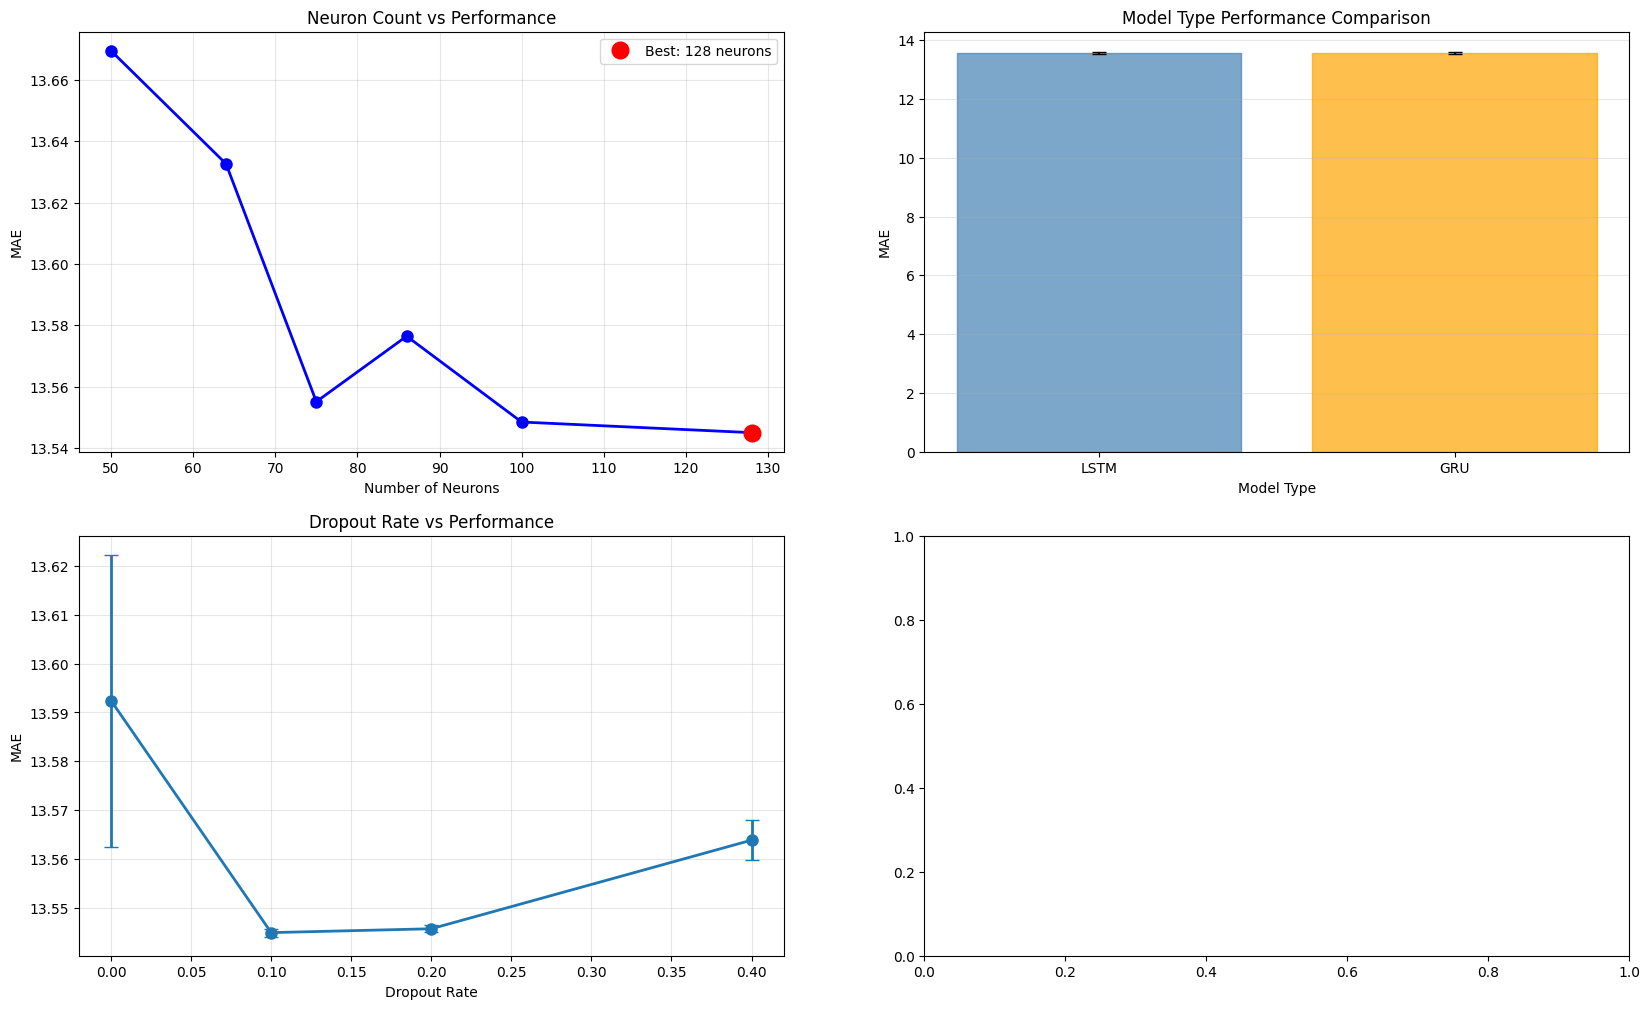

In [10]:
# Save tuning results to CSV files
save_tuning_results(neuron_results, grid_search_results, args.output_dir)

# Create and save visualization plots
plot_tuning_results(neuron_results, grid_search_results, args.output_dir)

print("\n📊 Results and plots saved successfully!")

## Final Summary

Display the complete tuning summary with best configuration details.


In [11]:
# Display final summary (same as main function output)
print(f"\n{'='*60}")
print(f"RNN TUNING SUMMARY")
print(f"{'='*60}")

print(f"Best configuration MAE: {best_config['mae']:.4f}")
print(f"\nBest configuration details:")
print(f"  Model type: {best_config['model_type']}")
print(f"  Architecture: {best_config['architecture']}")
print(f"  Hidden size: {best_config['hidden_size']}")
print(f"  Layers: {best_config['num_layers']}")
print(f"  Dropout: {best_config['dropout']}")

print(f"\n📁 Output files generated:")
print(f"  - {args.output_dir}/rnn_neuron_tuning_results.csv")
print(f"  - {args.output_dir}/rnn_grid_search_results.csv")
print(f"  - Visualization plots in {args.output_dir}")

print(f"\n✅ RNN hyperparameter tuning completed successfully!")


RNN TUNING SUMMARY
Best configuration MAE: 13.5428

Best configuration details:
  Model type: GRU
  Architecture: GRU-2layer
  Hidden size: 128
  Layers: 2
  Dropout: 0.0

📁 Output files generated:
  - tuning/results/rnn_neuron_tuning_results.csv
  - tuning/results/rnn_grid_search_results.csv
  - Visualization plots in tuning/results

✅ RNN hyperparameter tuning completed successfully!


## View Results Summary

Display a quick summary of the tuning results.


In [12]:
import pandas as pd

# Display neuron tuning results
print("\n📊 NEURON TUNING RESULTS:")
neuron_df = pd.DataFrame(neuron_results)
print(neuron_df.sort_values('mae'))

# Display top 5 grid search results
print("\n📊 TOP 5 GRID SEARCH RESULTS:")
grid_search_df = pd.DataFrame(grid_search_results)
top_5 = grid_search_df.nsmallest(5, 'mae')
print(top_5[['model_type', 'num_layers', 'dropout', 'mae']])


📊 NEURON TUNING RESULTS:
   hidden_size        mae
5          128  13.545000
4          100  13.548456
2           75  13.555089
3           86  13.576434
1           64  13.632625
0           50  13.669458

📊 TOP 5 GRID SEARCH RESULTS:
  model_type  num_layers  dropout        mae
6        GRU           2      0.0  13.542810
3       LSTM           2      0.1  13.544109
4       LSTM           2      0.2  13.545000
7        GRU           2      0.1  13.545751
8        GRU           2      0.2  13.546441


In [13]:
from google.colab import runtime
runtime.unassign()